In [1]:
from __future__ import division

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from matplotlib import finance

%matplotlib inline

# Loading and Exploring the Data

Below is a link to the entire dataset used.  This dataset is 1.63GB, so it may take some time to download.  Also note that it will take ~2 minutes for the data to load when running the notebook:

https://drive.google.com/open?id=0Byss1RfRw2XvU0tqMzRndmhaNEU

In [2]:
data = pd.read_csv('WIKI_20160608.csv', names=['Ticker', 'Date', 'Open', 'High', 'Low', 'Close',
                                              'Volume', '7', '8', 'Adj-O', 'Adj-H', 'Adj-L', 'Adj-C',
                                              'Adj-Vol'])

In [3]:
data.head(5)

,Ticker,Date,Open,High,Low,Close,Volume,7,8,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol
0,A,1999-11-18,45.50,50.00,40.00,44.00,44739900.0,0.0,1.0,43.584507,47.895063,38.316050,42.147655,44739900.0
1,A,1999-11-19,42.94,43.00,39.81,40.38,10897100.0,0.0,1.0,41.132280,41.189754,38.134049,38.680053,10897100.0
2,A,1999-11-22,41.31,44.00,40.06,44.00,4705200.0,0.0,1.0,39.570901,42.147655,38.373524,42.147655,4705200.0
3,A,1999-11-23,42.50,43.63,40.25,40.25,4274400.0,0.0,1.0,40.710803,41.793232,38.555525,38.555525,4274400.0
4,A,1999-11-24,40.13,41.94,40.00,41.06,3464400.0,0.0,1.0,38.440577,40.174379,38.316050,39.331425,3464400.0


Create a new dataframe with only the adjusted data, data, & ticker symbol.

In [4]:
dat = data[['Ticker', 'Date', 'Adj-O', 'Adj-H', 'Adj-L', 'Adj-C', 'Adj-Vol']]

In [5]:
dat.head(5)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol
0,A,1999-11-18,43.584507,47.895063,38.316050,42.147655,44739900.0
1,A,1999-11-19,41.132280,41.189754,38.134049,38.680053,10897100.0
2,A,1999-11-22,39.570901,42.147655,38.373524,42.147655,4705200.0
3,A,1999-11-23,40.710803,41.793232,38.555525,38.555525,4274400.0
4,A,1999-11-24,38.440577,40.174379,38.316050,39.331425,3464400.0


In [6]:
dat.shape

(14150093, 7)

Create a dataframe for a specific ticker

In [7]:
agilent = dat[dat['Ticker'] == 'A']

In [8]:
agilent.head()

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol
0,A,1999-11-18,43.584507,47.895063,38.316050,42.147655,44739900.0
1,A,1999-11-19,41.132280,41.189754,38.134049,38.680053,10897100.0
2,A,1999-11-22,39.570901,42.147655,38.373524,42.147655,4705200.0
3,A,1999-11-23,40.710803,41.793232,38.555525,38.555525,4274400.0
4,A,1999-11-24,38.440577,40.174379,38.316050,39.331425,3464400.0


Pretty straight forward to get a ticker specific set of data.  Below I will create a function to automate the process.

In [9]:
def tick_gettr(ticker):
    data = dat[dat['Ticker'] == ticker]
    return data

I will also create an array for all tickers in the dataset in case that comes in handy.

In [10]:
tickers = dat['Ticker']
tickers = tickers.unique()
len(tickers)

3179

Now I will get a ticker specific set of data to work with.

In [11]:
aapl = tick_gettr('AAPL')

## Basic Calculations

I first need to create the RSI components and determine how many days my moving average will be built with.

I will begin by creating the relative strength component.  Instead of hardcoding a number of days for the moving average I want to be able to look at different averages.  Below I will write a couple of functions to create the RSI.

RS:

In [12]:
def rs(ticker, look_back):
    """
    A function to find the relative strength of a stock using a user specified
    look back period.
    """
    
    #Get the difference between consecutive adjusted closes.
    difference = ticker['Adj-C'].diff()
    difference = difference[1:]
    
    #Define & clean up the up sessions & down sessions.
    up, down = difference.copy(), difference.copy()
    
    up[up < 0] = 0
    down[down > 0] = 0
    
    #Get the absolute value for the down sessions.
    down = down.abs()
    
    #Get the look_back mean for both up & down sessions.
    upper = up.rolling(window=look_back, center=False).mean()
    downer = down.rolling(window=look_back, center=False).mean()
        
    #Calculate the relative strength
    rs = upper / downer
    
    return rs

RSI:

In [13]:
def rsi(ticker, look_back):
    """
    A function that determines the relative strength index of a specific stock.
    """
    
    #Get the relative strength.
    r_s = rs(ticker, look_back)
    #Calculate the RSI.
    rsi = 100.0 - 100.0 / (1.0 + r_s)

    return rsi.round(decimals=2)

The Python code to get the RS calculation was greatly informed from this StackOverflow answer:

##### http://stackoverflow.com/a/29400434/1094634

Also important to note, that some sources will calculate some elements of the RSI differently.  Yahoo Finance & ThinkorSwim for instances calculate it the same (and differently from the above calculation) while Freestockcharts.com (Worden) calculates it the same way as the above functions.

### Buy/Sell Rule:

I will need some rules to determine when to buy & when to sell.  I will begin with a simple buy/sell rule.  Buy @ the closing price when RSI < 30 & sell @ the closing price when RSI > 70.  The 30 & 70 thresholds are the traditional demarcation points for 'oversold' (<30) & 'overbought' (>70) while using the RSI.  These thresholds are ripe for fine tuning.  Initially, I will be using the 14 day average.  The other average that I want to look at is the 9 day.  As with the oversold/overbought level, the optimal average needs to be tested/tuned as well.

Simply, what I want to know is if the RSI predicts higer prices from the buy point.  The actual price itself is not very important (although will be useful.)  If the sell price is consistently higher than the buy price, then I will interpret that as the RSI having some predictive value (whether or not the RSI strategy is more profitable than simply buying & holding the S&P 500 or the individual issues I use is a separate question.)


First, I will get Apples (AAPL) RSI using the 14 day average.

In [14]:
aapl_rsi = rsi(aapl, 14)

Now I want to add a new column to the dataset to include the RSI

In [15]:
aapl['RSI'] = aapl_rsi

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [16]:
aapl.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI
39644,AAPL,1980-12-12,0.436051,0.437871,0.436051,0.436051,117258400.0,NaN
39645,AAPL,1980-12-15,0.415273,0.415273,0.413301,0.413301,43971200.0,NaN


Next I want to remove the first 14 columsn with NaNs for the RSI

In [17]:
aapl = aapl[14:]

In [18]:
aapl.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI
39658,AAPL,1981-01-05,0.513706,0.513706,0.511886,0.511886,8932000.0,64.5
39659,AAPL,1981-01-06,0.490956,0.490956,0.489136,0.489136,11289600.0,64.5


Now I want to create some more columns that will show the prices for days where the RSI is < 30 & > 70.  Since I am going to do this repeatedly, I want to create a function to handle this process.

In [19]:
def price_columns(data, overbot, oversold):
    """
    A function that adds and populates the 'Sell Price' and 'Buy Price' columns for
    the dataset that is being used.
    
    overbot & oversold are ints
    """
    number_observations = len(data)
    data['Sell Price'] = pd.Series(0, np.arange(number_observations))
    #Populate the 'Sell Price' column with the relevant overbought data.
    data.ix[data.RSI > overbot, 'Sell Price'] = data['Adj-C']
    data['Buy Price'] = pd.Series(0, np.arange(number_observations))
    #Populate the 'Buy Price' column with the relevant oversold data.
    data.ix[data.RSI < oversold, 'Buy Price'] = data['Adj-C']
    
    return data

In [20]:
aapl = price_columns(aapl, 70, 30)

In [21]:
aapl.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price
39658,AAPL,1981-01-05,0.513706,0.513706,0.511886,0.511886,8932000.0,64.5,NaN,NaN
39659,AAPL,1981-01-06,0.490956,0.490956,0.489136,0.489136,11289600.0,64.5,NaN,NaN


Since I will also be prepping the data for multiple datasets repeatedly I want to do the RSI prep work above automatically as well.  I will write a function to handle prepping the data to include the RSI column.

In [22]:
def rsi_add(data, ave_length):
    """
    A function that will call rsi() to create the relevant RSI data & then add
    the RSI column to the relevant dataset.
    
    ave_length is an int
    """
    data_rsi = rsi(data, ave_length)
    data['RSI'] = data_rsi
    data = data[ave_length:]
    
    return data

I will also create several columns that represent holding periods of 1, 3, 5, & 10 days.  I think it will be beneficial to see whether or not arbitrary holding periods show better returns then the RSI > 70 sell point.  These holding periods can be played with and they are picked to represent the shorter term nature of this type of trade.

In [23]:
base = aapl.copy()
base = base['Adj-C']

day_1 = base.shift(-1)
day_3 = base.shift(-3)
day_5 = base.shift(-5)
day_10 = base.shift(-10)

In [24]:
aapl['Day 1'] = day_1
aapl['Day 3'] = day_3
aapl['Day 5'] = day_5
aapl['Day 10'] = day_10

In [25]:
aapl.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price,Day 1,Day 3,Day 5,Day 10
39658,AAPL,1981-01-05,0.513706,0.513706,0.511886,0.511886,8932000.0,64.5,NaN,NaN,0.489136,0.458802,0.479581,0.498539
39659,AAPL,1981-01-06,0.490956,0.490956,0.489136,0.489136,11289600.0,64.5,NaN,NaN,0.468357,0.483524,0.462594,0.483524


Now I have a dataset to begin working with.

# Analyzing the Data

### A simple and naive regression

First I am going to run a simple regression of the RSI column against the adjusted close column to see what that looks like.

In [26]:
aapl_prices = aapl[['Adj-C']]
aapl_rsi_d = aapl[['RSI']]

### Splitting the training & test data.

I will do this automatically as well, but since the historical order of the data is important I will write a function to handle this.  I want to train the model on the older data and test it on the newer data to see if there is any predictive abilities.  A **caveat** here, however, this where many of these types of strategies and analytical approaches end up overfitting and producing models the have *disatsrous* results in the real world.

In [27]:
def train_test(data, features, prediction, train):
    """
    A function that splits the dataset into training & testing sets while preserving chronological order.
    
    features = a list of strs that are will be used to train the models.
    prediction = a list of a str that the model will be attempting to predict.
    train = a float that represents the % of the dataset used for the training set.
    """
    #Create our features & predictions
    data_preds = data[prediction]
    data_feats = data[features]
    
    #Use the train percent to get an int that will represent the index cut off point for
    #the data sets
    train_percent = int(round(len(data) * train))
    
    #Split the features & predictions into their train/test splits
    train_preds = data_preds[:train_percent]
    train_feats = data_feats[:train_percent]
    test_preds = data_preds[train_percent:]
    test_feats = data_feats[train_percent:]
    
    return train_preds, train_feats, test_preds, test_feats

In [28]:
aapl_preds, aapl_feats, aapl_testp, aapl_testf = train_test(aapl, ['RSI'], ['Adj-C'], .8)

Now I will create a simple, naive linear regression model

In [29]:
from sklearn.linear_model import LinearRegression

In [30]:
simple_linear = LinearRegression()
simple_linear.fit(aapl_feats, aapl_preds)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [31]:
predicted_price = simple_linear.predict(aapl_testf)

In [32]:
simple_linear.score(aapl_testf, aapl_testp)

-4.4864101023722318

Not a very good score.

Let's see what the RSS is.

In [33]:
np.sum((predicted_price - aapl_testp) ** 2)

Adj-C    9.356749e+06
dtype: float64

That's a pretty large number, again not a very good result for this very simplistic regression model.

I want to plot this out to see what these predicted results look like.

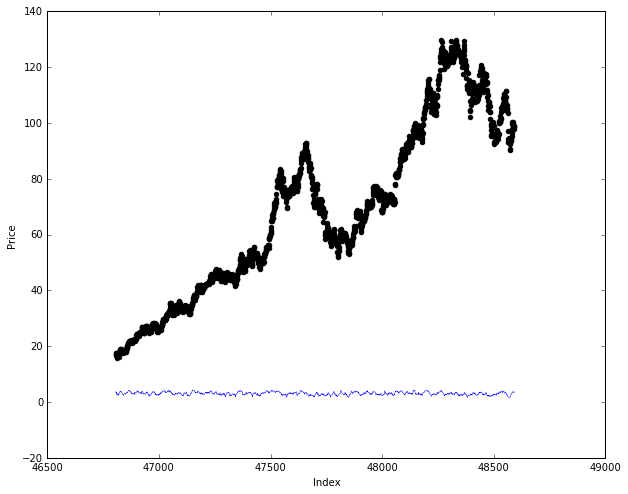

In [34]:
plt.figure(figsize=(10,8))
plt.scatter(aapl_testf.index, aapl_testp, color='black')
plt.ylabel('Price')
plt.xlabel('Index')
plt.plot(aapl_testf.index, predicted_price, color='blue', linewidth=.5)

Obviously simply using the RSI values without any type of filter to predict prices is not effective.

Now I will use a number of features to see what the result is.

In [35]:
multi_naive_features = ['Adj-O', 'Adj-H', 'Adj-L', 'Adj-Vol', 'RSI']

In [36]:
aapl_preds, aapl_feats, aapl_testp, aapl_testf = train_test(aapl, multi_naive_features, ['Adj-C'], .8)

In [37]:
multi_simple_linear = LinearRegression()
multi_simple_linear.fit(aapl_feats, aapl_preds)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [38]:
predicted_price = multi_simple_linear.predict(aapl_testf)

Check the regression score:

In [39]:
multi_simple_linear.score(aapl_testf, aapl_testp)

0.99981783502231891

Now calculate the RSS:

In [40]:
np.sum((predicted_price - aapl_testp) ** 2)

Adj-C    310.671642
dtype: float64

This seems a little too good, so now I will plot my predictions.

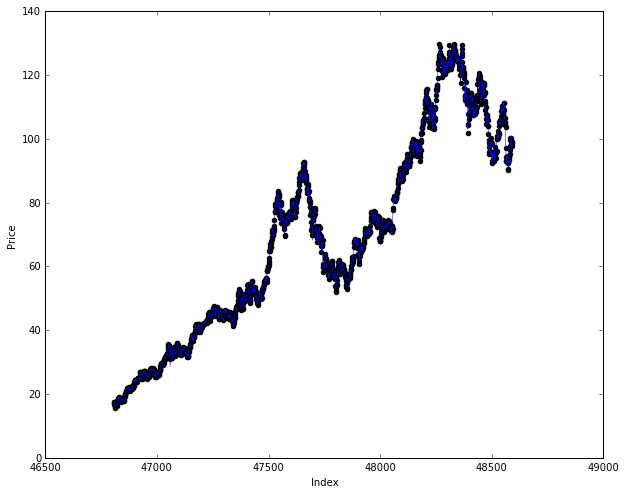

In [41]:
plt.figure(figsize=(10,8))
plt.scatter(aapl_testf.index, aapl_testp, color='black')
plt.ylabel('Price')
plt.xlabel('Index')
plt.plot(aapl_testf.index, predicted_price, color='blue', linewidth=.5)

Where in the first naive regression I had no correlation whatsoever, this one seems to be too good to be true.

Now I what to use the RSI buy/sell thresholds in order to see if I these thresholds are predictive.  I will use linear regression and decision tree regression.

First I want to create another column that will show the post buy sell signal price.  I want to keep a sell column as well, since it theoretically possible to use the overbought signal as signal to short.  Anecdotally the short signal using RSI hasn't not been considered very successful and any number of theories as to why have been floated, however, I have never tested this and want to keep that option open.

I will create another new column, 'Sell Signal Price', which will hold the closing price when the sell signal is generated.  I will again create a function to create this column and then populate it.

In [42]:
def sell_signal_prices(data, overbot, oversold):
    """
    This function will create the 'Sell Signal Column' and populate it with data.
    
    overbot & oversold are ints that represent the relevant thresholds for the RSI.
    """
    
    observations = len(data)
    #Create an empty column and replace the NaNs with 0s.
    data['Sell Signal Price'] = pd.Series(0, np.arange(observations))
    data = data.fillna(0)
    
    #Create a temporary dataframe.
    temp_frame = data[['Adj-C', 'RSI', 'Sell Price', 'Buy Price', 'Sell Signal Price']]
    
    #Loop through the temporary dataframe to populate the 'Sell Signal Price' column with data.
    for price in temp_frame.iterrows():
        if 0 < price[1][1] < oversold:
            place = temp_frame.query(price[0])
            p_start = temp_frame.index.get_loc(place.name)
            temp_list = temp_frame[p_start:]

            for i in temp_list.iterrows():
                if i[1][1] > overbot:
                    price[1][4] = i[1][0]
                    break
    
    #Populate the new column in the original dataframe with the sell price data.
    data['Sell Signal Price'] = temp_frame['Sell Signal Price']
    
    return data

Now I will test the new function with the aapl dataset.  I know location of the first RSI < 30 observation so I will use that observation to see if the function works.

In [43]:
aapl.iloc[9]

Ticker              AAPL
Date          1981-01-16
Adj-O           0.471997
Adj-H           0.471997
Adj-L           0.470177
Adj-C           0.470177
Adj-Vol       3.3488e+06
RSI                29.55
Sell Price           NaN
Buy Price       0.470177
Day 1           0.498539
Day 3           0.492928
Day 5           0.496719
Day 10          0.428468
Name: 39667, dtype: object

In [44]:
aapl = sell_signal_prices(aapl, 70, 30)

In [45]:
aapl.iloc[9]

Ticker                     AAPL
Date                 1981-01-16
Adj-O                  0.471997
Adj-H                  0.471997
Adj-L                  0.470177
Adj-C                  0.470177
Adj-Vol              3.3488e+06
RSI                       29.55
Sell Price                    0
Buy Price              0.470177
Day 1                  0.498539
Day 3                  0.492928
Day 5                  0.496719
Day 10                 0.428468
Sell Signal Price      0.399954
Name: 39667, dtype: object

Success!

Now I want to use this dataset to run some regressions using linear regression and decision tree regeression.

## Running the Regeressions

First I will choose which features I want to use and then I will split up my train/test data.

In [46]:
rsi_features = ['RSI', 'Buy Price']

aapl_preds, aapl_feats, aapl_testp, aapl_testf = train_test(aapl, rsi_features, ['Sell Signal Price'], .8)

### Linear Regression

In [47]:
rsi_30_model = LinearRegression()
rsi_30_model.fit(aapl_feats, aapl_preds)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [48]:
predicted30_prices = rsi_30_model.predict(aapl_testf)

Score & RSS:

In [49]:
rsi_30_model.score(aapl_testf, aapl_testp)

0.98512976758219584

In [50]:
np.sum((predicted30_prices - aapl_testp) ** 2)

Sell Signal Price    11671.091729
dtype: float64

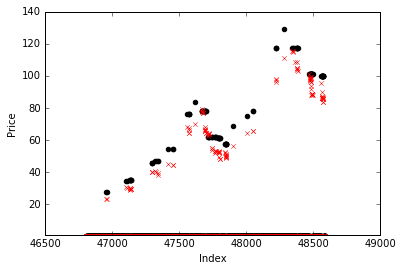

In [51]:
plt.scatter(aapl_testf.index, aapl_testp, color='black')
plt.ylabel('Price')
plt.xlabel('Index')
plt.ylim(ymin=1)
plt.scatter(aapl_testf.index, predicted30_prices, color='red', linewidth=.5, marker='x')

### Decision Tree Regression

I am going to use three different max depths (2, 5, 20.)

In [52]:
from sklearn.tree import DecisionTreeRegressor

In [53]:
trereg_2 = DecisionTreeRegressor(max_depth=2)
trereg_5 = DecisionTreeRegressor(max_depth=5)
trereg_20 = DecisionTreeRegressor(max_depth=20)

In [54]:
trereg_2.fit(aapl_feats, aapl_preds)
trereg_5.fit(aapl_feats, aapl_preds)
trereg_20.fit(aapl_feats, aapl_preds)

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [55]:
predict_2 = trereg_2.predict(aapl_testf)
predict_5 = trereg_5.predict(aapl_testf)
predict_20 = trereg_20.predict(aapl_testf)

Now I want to see the scores & RSSs.

First I have to clean up the test prices.

In [56]:
testp_matrix = aapl_testp.as_matrix(columns=['Sell Signal Price'])
testp_matrix = testp_matrix.reshape((1787, ))

Max depth 2:

In [57]:
trereg_2.score(aapl_testf, aapl_testp)

0.29166041143263166

In [58]:
np.sum((predict_2 - testp_matrix) ** 2)

555949.3679156045

Max depth 5:

In [59]:
trereg_5.score(aapl_testf, aapl_testp)

0.27080168559486484

In [60]:
np.sum((predict_5 - testp_matrix) ** 2)

572320.60514729063

Max depth 20:

In [61]:
trereg_20.score(aapl_testf, aapl_testp)

0.28458236425208561

In [62]:
np.sum((predict_2 - testp_matrix) ** 2)

555949.3679156045

Better than the naive regression I ran further up, but fairly mediocre.

Now I will plot these to see what they look like.

First, max depth 2:

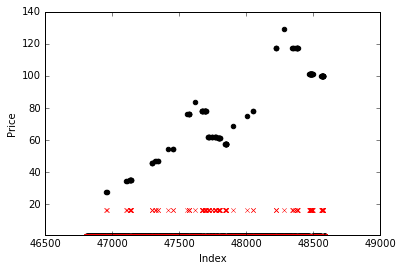

In [63]:
plt.scatter(aapl_testf.index, aapl_testp, color='black')
plt.ylabel('Price')
plt.xlabel('Index')
plt.ylim(ymin=1)
plt.scatter(aapl_testf.index, predict_2, color='red', linewidth=.5, marker='x')

Max depth 5:

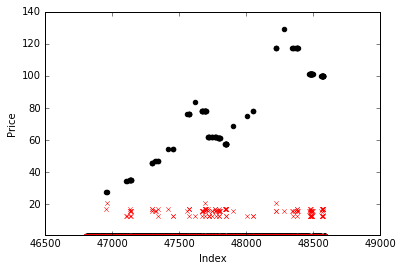

In [64]:
plt.scatter(aapl_testf.index, aapl_testp, color='black')
plt.ylabel('Price')
plt.xlabel('Index')
plt.ylim(ymin=1)
plt.scatter(aapl_testf.index, predict_5, color='red', linewidth=.5, marker='x')

Max depth 20:

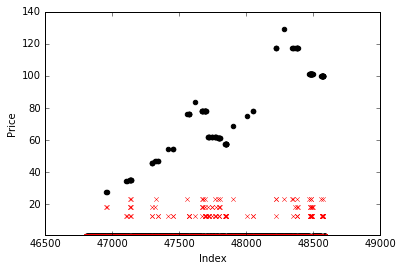

In [65]:
plt.scatter(aapl_testf.index, aapl_testp, color='black')
plt.ylabel('Price')
plt.xlabel('Index')
plt.ylim(ymin=1)
plt.scatter(aapl_testf.index, predict_20, color='red', linewidth=.5, marker='x')

Not very impressive results.

## Using holding periods

I want to also see if there is some predictive outcome by simply holding onto a position after a buy signal is genereated.  In order to avoid training each possibilty by hand, I'll now write a function to automate the process.  This idea is inspired by University of Washingtons Linear Regression course on Coursera.

In [66]:
periods = ['Day 1', 'Day 3', 'Day 5', 'Day 10']
hold_features = ['RSI', 'Buy Price']

aapl_hold = aapl[['RSI', 'Buy Price', 'Day 1', 'Day 3', 'Day 5', 'Day 10']]

In [67]:
def predictor(data, periods, features, train):
    """
    A function to automate the modeling for linear regression.
    
    data = the data set that the models will be trained on and predictions made from.
    periods = contains a list of the columns with the relevant price data.
    features = a list of strs that are will be used to train the models.
    train = a float that represents the % of the dataset used for the training set.
    """
    
    observations = len(data)
    train_percent = int(round(observations * train))
    
    #Create and prepare the feature data set.
    features = data[features]
    features = features.fillna(0)
#     features = features.reshape((8935,1))
    train_f = features[:train_percent]
    test_f = features[train_percent:]
    
    for i in periods:
        #Create and prepare the price data set.
        prices = data[i]
        prices = prices.fillna(0)
        prices = prices.reshape((observations,1))
        
        train_p = prices[:train_percent]
        test_p = prices[train_percent:]
        
        #Train model & make predictions.
        model = LinearRegression()
        model.fit(train_f, train_p)
        predictions = model.predict(test_f)
        
        #Get RSS.
        rss = np.sum((predictions - test_p) ** 2)
        
        #Model score.
        score = model.score(test_f, test_p)
        
        print "The score, {}, and RSS, {}, of the model for {}".format(score, rss, i)
    

In [68]:
predictor(aapl_hold, periods, hold_features, .8)

The score, -4.05448784097, and RSS, 8630669.29191, of the model for Day 1
The score, -4.04152152132, and RSS, 8629283.47635, of the model for Day 3
The score, -4.03151988386, and RSS, 8632681.31584, of the model for Day 5
The score, -4.00502160549, and RSS, 8636099.24864, of the model for Day 10


As we can see here, simply using holding periods does not perform better than the first naive regression attempts.

I also want to see if the actual "returns" (defined here simply as the sum of the difference between the buy price & sell signal price) were positive.  This is not an actual backtest, but more of a quick look to see whether or not a simple strategy of buy & selling using the RSI 30/70 generated a positive or negative result.

In [69]:
aapl.shape

(8935, 15)

In [70]:
aapl.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price,Day 1,Day 3,Day 5,Day 10,Sell Signal Price
39658,AAPL,1981-01-05,0.513706,0.513706,0.511886,0.511886,8932000.0,64.5,0.0,0.0,0.489136,0.458802,0.479581,0.498539,0.0
39659,AAPL,1981-01-06,0.490956,0.490956,0.489136,0.489136,11289600.0,64.5,0.0,0.0,0.468357,0.483524,0.462594,0.483524,0.0


In [71]:
comp_list = []

for line in aapl.iterrows():
    if line[1][14] > 0:
        asd = line[1][14] - line[1][5]
        comp_list.append(asd)
        
sum(comp_list)

272.92292481936585

Again, this isn't meant to replace a legitmate backtest, but simply a quick look to see if buying & selling over the life (or at least our dataset) of a security produced a positve result.  When we start to factor in comissions, slippage, risk management, and position size the actual results would be different from this "back of the envelope" calculation.


# Using Different Thresholds & Timeframes

I will begin by using the 9 day moving average mentioned above.  The timeframe of moving averages tend to be arbitrary and rely upon customs that have been used by technical analysts & chartists over the decades.  No doubt as the increased quantification of trading & finance many of these moving averages (m.a.) have come under scrutiny there is still heavy reliance on the traditional metrics (e.g. the 50 & 200 day m.a.)

I will once again use Apple as the test stock.  I will now use the 9 day RSI.

In [72]:
aapl9 = tick_gettr('AAPL')

In [73]:
aapl9_rsi = rsi(aapl9, 9)
aapl9['RSI'] = aapl9_rsi

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [74]:
aapl9 = aapl9[9:]

In [75]:
aapl9.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI
39653,AAPL,1980-12-26,0.538429,0.540249,0.538429,0.538429,13893600.0,74.55
39654,AAPL,1980-12-29,0.546012,0.547984,0.546012,0.546012,23290400.0,84.31


In [76]:
aapl9 = price_columns(aapl9, 70, 30)

In [77]:
aapl9.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price
39653,AAPL,1980-12-26,0.538429,0.540249,0.538429,0.538429,13893600.0,74.55,0.538429,NaN
39654,AAPL,1980-12-29,0.546012,0.547984,0.546012,0.546012,23290400.0,84.31,0.546012,NaN


I will also add the holding period columns in order to have consistent datasets that are used for analysis.

In [78]:
base9 = aapl9.copy()
base9 = base9['Adj-C']

day_1 = base9.shift(-1)
day_3 = base9.shift(-3)
day_5 = base9.shift(-5)
day_10 = base9.shift(-10)

In [79]:
aapl9['Day 1'] = day_1
aapl9['Day 3'] = day_3
aapl9['Day 5'] = day_5
aapl9['Day 10'] = day_10

In [80]:
aapl9.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price,Day 1,Day 3,Day 5,Day 10
39653,AAPL,1980-12-26,0.538429,0.540249,0.538429,0.538429,13893600.0,74.55,0.538429,NaN,0.546012,0.517650,0.511886,0.479581
39654,AAPL,1980-12-29,0.546012,0.547984,0.546012,0.546012,23290400.0,84.31,0.546012,NaN,0.532665,0.523262,0.489136,0.462594


Finally, I will add the Sell Signal Price column.

In [81]:
aapl9 = sell_signal_prices(aapl9, 70, 30)

In [82]:
aapl9.iloc[13]

Ticker                     AAPL
Date                 1981-01-15
Adj-O                  0.473969
Adj-H                  0.477761
Adj-L                  0.473969
Adj-C                  0.473969
Adj-Vol              3.5168e+06
RSI                       29.71
Sell Price                    0
Buy Price              0.473969
Day 1                  0.470177
Day 3                  0.483524
Day 5                  0.498539
Day 10                 0.453038
Sell Signal Price      0.405717
Name: 39666, dtype: object

The above observation is the first instance of the RSI falling below 30 in the first Apple dataset, that's why it's used here as well to check and see if I've successfully added the sell signal price.

Now I will move onto running the regressions.  I will forgo running the models on the holding periods since they were no better than the first set of "naive" regressions.

First I will create my train/test splits.  I will use the same features as above.

In [83]:
aapl_preds, aapl_feats, aapl_testp, aapl_testf = train_test(aapl9, rsi_features, ['Sell Signal Price'], .8)

## Linear Regression

In [84]:
rsi_309_model = LinearRegression()
rsi_309_model.fit(aapl_feats, aapl_preds)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [85]:
aapl309_predictions = rsi_309_model.predict(aapl_testf)

In [86]:
rsi_309_model.score(aapl_testf, aapl_testp)

0.99313047238565977

In [87]:
np.sum((aapl309_predictions - aapl_testp) ** 2)

Sell Signal Price    9260.092403
dtype: float64

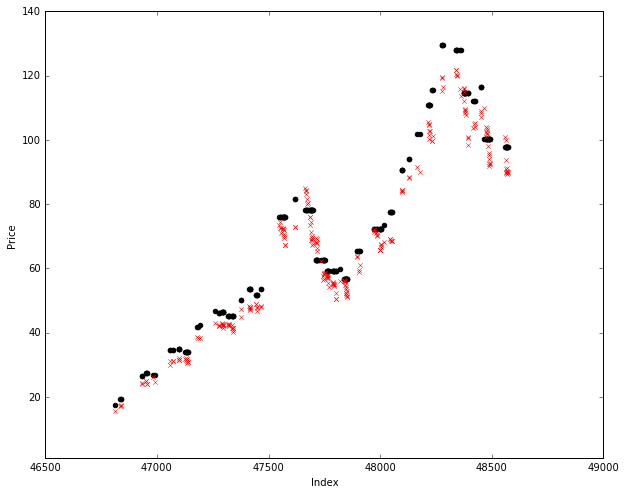

In [88]:
plt.figure(figsize=(10,8))
plt.scatter(aapl_testf.index, aapl_testp, color='black')
plt.ylabel('Price')
plt.xlabel('Index')
plt.ylim(ymin=1)
plt.scatter(aapl_testf.index, aapl309_predictions, color='red', linewidth=.5, marker='x')

It looks as though I am fitting the curve very tightly.  This is somewhat expected actually.  One of the most persistent issues with machine learning and trading is the overfitting problem.  Here we see with more trading events, the model is in fact fitting the data almost perfectly.

Now I will run the decision tree regression.

In [89]:
trereg_2309 = DecisionTreeRegressor(max_depth=2)
trereg_5309 = DecisionTreeRegressor(max_depth=5)
trereg_20309 = DecisionTreeRegressor(max_depth=20)

In [90]:
trereg_2309.fit(aapl_feats, aapl_preds)
trereg_5309.fit(aapl_feats, aapl_preds)
trereg_20309.fit(aapl_feats, aapl_preds)

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [91]:
predict_2309 = trereg_2309.predict(aapl_testf)
predict_5309 = trereg_5309.predict(aapl_testf)
predict_20309 = trereg_20309.predict(aapl_testf)

**Scores & RSS**

In [92]:
print "Max depth 2 score: {}".format(trereg_2309.score(aapl_testf, aapl_testp))
print "Max depth 5 score: {}".format(trereg_5309.score(aapl_testf, aapl_testp))
print "Max depth 20 score: {}".format(trereg_20309.score(aapl_testf, aapl_testp))

Max depth 2 score: 0.286652608931
Max depth 5 score: 0.286379440629
Max depth 20 score: 0.313487783451


In [93]:
rsi_9_actual = aapl_testp.as_matrix(columns=['Sell Signal Price'])
rsi_9_actual =  rsi_9_actual.reshape((1788,))

In [94]:
print "Max depth 2 RSS: {}".format(np.sum((predict_2309 - rsi_9_actual) ** 2))
print "Max depth 5 RSS: {}".format(np.sum((predict_5309 - rsi_9_actual) ** 2))
print "Max depth 20 RSS: {}".format(np.sum((predict_20309 - rsi_9_actual) ** 2))

Max depth 2 RSS: 961589.082591
Max depth 5 RSS: 961957.312237
Max depth 20 RSS: 925415.387739


**Charts**

Max depth 2:

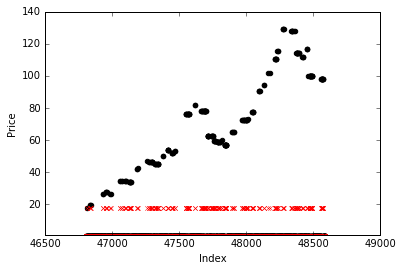

In [95]:
plt.scatter(aapl_testf.index, aapl_testp, color='black')
plt.ylabel('Price')
plt.xlabel('Index')
plt.ylim(ymin=1)
plt.scatter(aapl_testf.index, predict_2309, color='red', linewidth=.5, marker='x')

Max depth 5:

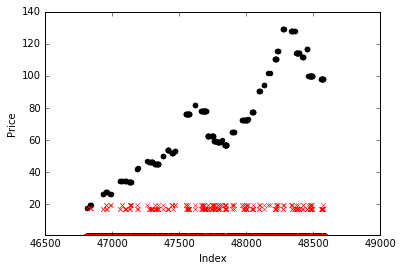

In [96]:
plt.scatter(aapl_testf.index, aapl_testp, color='black')
plt.ylabel('Price')
plt.xlabel('Index')
plt.ylim(ymin=1)
plt.scatter(aapl_testf.index, predict_5309, color='red', linewidth=.5, marker='x')

Max depth 20:

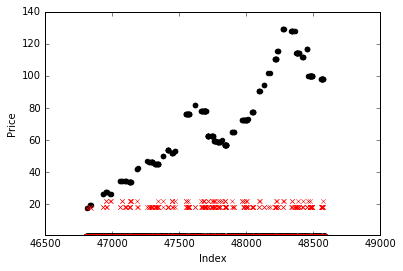

In [97]:
plt.scatter(aapl_testf.index, aapl_testp, color='black')
plt.ylabel('Price')
plt.xlabel('Index')
plt.ylim(ymin=1)
plt.scatter(aapl_testf.index, predict_20309, color='red', linewidth=.5, marker='x')

As with the decision tree with the 14 day RSI dataset, we see predictions that don't really correlate with the price data.  It seems pretty self evident that the decision tree is being overly impacted by the early data and is running into problems with predicting accurate prices.

I also want to make the same back of the envelope calculation as I did above to see what effect more trades had on this strategy.

In [98]:
comp_list_9 = []

for line in aapl9.iterrows():
    if line[1][14] > 0:
        asd = line[1][14] - line[1][9]
        comp_list_9.append(asd)
        
sum(comp_list_9)

489.68117861896803

In [99]:
print "RSI 14 day # of trades: {}, RSI 9 day # of trades: {}".format(len(comp_list), len(comp_list_9))

RSI 14 day # of trades: 905, RSI 9 day # of trades: 1436


This is an interesting outcome, since typically strategies with more trades have worse performance.  My expectation, even with this simplistic calculation, was that this sum total would be lower.  However, given that we are looking at only 905 & 1436 trades since 1980, this probably does not qualify as overtrading and my assumptions that the performance is worse for the 9 day RSI is probably unfounded.

Finally I want to consider a lower threshold for the buy signal.  I will use 25 as the lower threshold.  I will also do so on both of the 9 & 14 day datasets that I already have.


**14 Day**

In [100]:
aapl14_25 = tick_gettr('AAPL')
aapl14_25_rsi = rsi(aapl14_25, 14)
aapl14_25['RSI'] = aapl14_25_rsi
aapl14_25 = aapl14_25[14:]
aapl14_25.head(2)

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI
39658,AAPL,1981-01-05,0.513706,0.513706,0.511886,0.511886,8932000.0,64.5
39659,AAPL,1981-01-06,0.490956,0.490956,0.489136,0.489136,11289600.0,64.5


In [101]:
aapl14_25 = price_columns(aapl14_25, 70, 25)
aapl14_25.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price
39658,AAPL,1981-01-05,0.513706,0.513706,0.511886,0.511886,8932000.0,64.5,NaN,NaN
39659,AAPL,1981-01-06,0.490956,0.490956,0.489136,0.489136,11289600.0,64.5,NaN,NaN


In [102]:
base14_25 = aapl14_25.copy()
base14_25 = base14_25['Adj-C']

day_1 = base14_25.shift(-1)
day_3 = base14_25.shift(-3)
day_5 = base14_25.shift(-5)
day_10 = base14_25.shift(-10)

aapl14_25['Day 1'] = day_1
aapl14_25['Day 3'] = day_3
aapl14_25['Day 5'] = day_5
aapl14_25['Day 10'] = day_10

In [103]:
aapl14_25.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price,Day 1,Day 3,Day 5,Day 10
39658,AAPL,1981-01-05,0.513706,0.513706,0.511886,0.511886,8932000.0,64.5,NaN,NaN,0.489136,0.458802,0.479581,0.498539
39659,AAPL,1981-01-06,0.490956,0.490956,0.489136,0.489136,11289600.0,64.5,NaN,NaN,0.468357,0.483524,0.462594,0.483524


In [104]:
aapl14_25 = sell_signal_prices(aapl14_25, 70, 25)
aapl14_25.iloc[26]

Ticker                     AAPL
Date                 1981-02-10
Adj-O                  0.413301
Adj-H                  0.415273
Adj-L                  0.413301
Adj-C                  0.413301
Adj-Vol              4.5864e+06
RSI                       24.34
Sell Price                    0
Buy Price              0.413301
Day 1                  0.399954
Day 3                  0.386759
Day 5                  0.413301
Day 10                 0.382967
Sell Signal Price      0.399954
Name: 39684, dtype: object

In [105]:
aapl_preds, aapl_feats, aapl_testp, aapl_testf = train_test(aapl14_25, rsi_features, ['Sell Signal Price'], .8)

In [106]:
rsi_1425_model = LinearRegression()
rsi_1425_model.fit(aapl_feats, aapl_preds)
predictions_1425 = rsi_1425_model.predict(aapl_testf)

In [107]:
print "Score: {} & RSS: {}".format(rsi_1425_model.score(aapl_testf, aapl_testp), np.sum(
        (predictions_1425 - aapl_testp) ** 2))

Score: 0.976905234058 & RSS: Sell Signal Price    9384.264266
dtype: float64


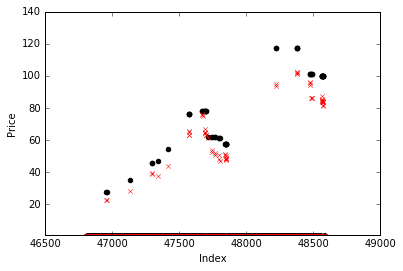

In [108]:
plt.scatter(aapl_testf.index, aapl_testp, color='black')
plt.ylabel('Price')
plt.xlabel('Index')
plt.ylim(ymin=1)
plt.scatter(aapl_testf.index, predictions_1425, color='red', linewidth=.5, marker='x')

In [109]:
comp_list1425 = []

for line in aapl14_25.iterrows():
    if line[1][14] > 0:
        asd = line[1][14] - line[1][9]
        comp_list1425.append(asd)
        
print len(comp_list1425), sum(comp_list1425)

498 184.515070095


**9 Day**

In [110]:
aapl9_25 = tick_gettr('AAPL')
aapl9_25_rsi = rsi(aapl9_25, 9)
aapl9_25['RSI'] = aapl9_25_rsi
aapl9_25 = aapl9_25[9:]
aapl9_25.head(2)

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI
39653,AAPL,1980-12-26,0.538429,0.540249,0.538429,0.538429,13893600.0,74.55
39654,AAPL,1980-12-29,0.546012,0.547984,0.546012,0.546012,23290400.0,84.31


In [111]:
aapl9_25 = price_columns(aapl9_25, 70, 25)
aapl9_25.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price
39653,AAPL,1980-12-26,0.538429,0.540249,0.538429,0.538429,13893600.0,74.55,0.538429,NaN
39654,AAPL,1980-12-29,0.546012,0.547984,0.546012,0.546012,23290400.0,84.31,0.546012,NaN


In [112]:
base9_25 = aapl9_25.copy()
base9_25 = base9_25['Adj-C']

day_1 = base9_25.shift(-1)
day_3 = base9_25.shift(-3)
day_5 = base9_25.shift(-5)
day_10 = base9_25.shift(-10)

aapl9_25['Day 1'] = day_1
aapl9_25['Day 3'] = day_3
aapl9_25['Day 5'] = day_5
aapl9_25['Day 10'] = day_10

aapl9_25.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price,Day 1,Day 3,Day 5,Day 10
39653,AAPL,1980-12-26,0.538429,0.540249,0.538429,0.538429,13893600.0,74.55,0.538429,NaN,0.546012,0.517650,0.511886,0.479581
39654,AAPL,1980-12-29,0.546012,0.547984,0.546012,0.546012,23290400.0,84.31,0.546012,NaN,0.532665,0.523262,0.489136,0.462594


In [113]:
aapl9_25 = sell_signal_prices(aapl9_25, 70, 25)
aapl9_25.iloc[26]

Ticker                     AAPL
Date                 1981-02-03
Adj-O                  0.418913
Adj-H                  0.420884
Adj-L                  0.418913
Adj-C                  0.418913
Adj-Vol               4.788e+06
RSI                       17.89
Sell Price                    0
Buy Price              0.418913
Day 1                   0.43408
Day 3                  0.436051
Day 5                  0.413301
Day 10                 0.413301
Sell Signal Price      0.405717
Name: 39679, dtype: object

In [114]:
aapl_preds_925, aapl_feats_925, aapl_testp_925, aapl_testf_925 = train_test(
    aapl9_25, rsi_features, ['Sell Signal Price'], .8)

In [115]:
rsi_925_model = LinearRegression()
rsi_925_model.fit(aapl_feats_925, aapl_preds_925)
predictions_925 = rsi_925_model.predict(aapl_testf_925)

In [116]:
print "Score: {} & RSS: {}".format(rsi_925_model.score(aapl_testf_925, aapl_testp_925), np.sum(
        (predictions_925 - aapl_testp_925) ** 2))

Score: 0.989580230991 & RSS: Sell Signal Price    9533.049306
dtype: float64


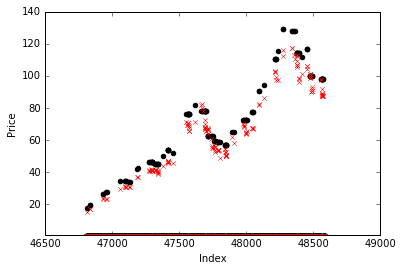

In [117]:
plt.scatter(aapl_testf_925.index, aapl_testp_925, color='black')
plt.ylabel('Price')
plt.xlabel('Index')
plt.ylim(ymin=1)
plt.scatter(aapl_testf_925.index, predictions_925, color='red', linewidth=.5, marker='x')

In [118]:
comp_list925 = []

for line in aapl9_25.iterrows():
    if line[1][14] > 0:
        asd = line[1][14] - line[1][9]
        comp_list925.append(asd)
        
print len(comp_list925), sum(comp_list925)

920 338.837499631


It looks as though there is no improvement over the 30 RSI level for the buy signals.  The thinking behind a lower buy signal threshold is relatively straight forward; the RSI is supposed to present good opportunities to go long (buy) in extreme events.  The RSI is a tool that looks to take advantage of mean reversion opportunities.  The difference between the 30 buy level & the 25 buy level is minimal, with the traditional level being the better of the two.  More interesting is number of days used to calculate the moving average.  The 9 day moving average is more predictive (marginally so) than the 14 day m.a.  The 9 day m.a., however, provides more opportunities to go long and produces almost twice the "returns" at least according to our back of the envelope calculation.  Next, I want to see what the results on other stocks.  The issues I will be looking at are MSFT, ZUMZ, IBM, & X.

**MSFT**

In [119]:
msft = tick_gettr('MSFT')
msft_rsi = rsi(msft, 9)
msft['RSI'] = msft_rsi
msft = msft[9:]
msft.head(2)

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI
8551433,MSFT,1986-03-26,0.063777,0.066184,0.063176,0.065582,22752000.0,44.00
8551434,MSFT,1986-03-27,0.065582,0.066786,0.065582,0.066786,16848000.0,39.13


In [120]:
msft = price_columns(msft, 70, 30)
msft.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price
8551433,MSFT,1986-03-26,0.063777,0.066184,0.063176,0.065582,22752000.0,44.00,NaN,NaN
8551434,MSFT,1986-03-27,0.065582,0.066786,0.065582,0.066786,16848000.0,39.13,NaN,NaN


In [121]:
base_msft = msft.copy()
base_msft = msft['Adj-C']

day_1 = base_msft.shift(-1)
day_3 = base_msft.shift(-3)
day_5 = base_msft.shift(-5)
day_10 = base_msft.shift(-10)

msft['Day 1'] = day_1
msft['Day 3'] = day_3
msft['Day 5'] = day_5
msft['Day 10'] = day_10

msft.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price,Day 1,Day 3,Day 5,Day 10
8551433,MSFT,1986-03-26,0.063777,0.066184,0.063176,0.065582,22752000.0,44.00,NaN,NaN,0.066786,0.065582,0.066786,0.067989
8551434,MSFT,1986-03-27,0.065582,0.066786,0.065582,0.066786,16848000.0,39.13,NaN,NaN,0.066184,0.066184,0.066786,0.069193


In [122]:
msft = sell_signal_prices(msft, 70, 30)

MSFT Features

In [123]:
msft_features = msft[rsi_features]
# msft_preds, msft_feats, msft_testp, msft_testf = train_test(
#     msft, rsi_features, ['Sell Signal Price'], .8)

Now I am going to fit the MSFT data to the rsi_309_model.

In [124]:
# rsi_309_model.fit(msft_feats, msft_preds)
msft_predictions = rsi_309_model.predict(msft_features)

In [125]:
msft_prices = msft['Sell Signal Price']
msft_prices = msft_prices.reshape((7604, 1))

**Score & RSS**

In [126]:
rsi_309_model.score(msft_features, msft_prices)

0.99088780111471553

In [127]:
np.sum((msft_predictions - msft_prices) ** 2)

4059.2439652341886

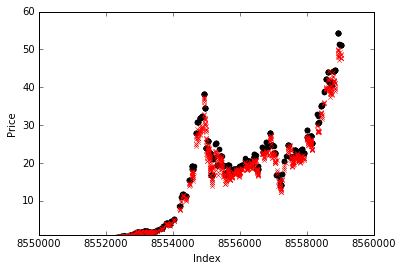

In [128]:
plt.scatter(msft_features.index, msft_prices, color='black')
plt.ylabel('Price')
plt.xlabel('Index')
plt.ylim(ymin=1)
plt.scatter(msft_features.index, msft_predictions, color='red', linewidth=.5, marker='x')

**ZUMZ**

In [129]:
zumz = tick_gettr('ZUMZ')
zumz_rsi = rsi(zumz, 9)
zumz['RSI'] = zumz_rsi
zumz = zumz[9:]
zumz.head(2)

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI
14147326,ZUMZ,2005-05-19,12.97,12.970,12.500,12.85,93600.0,58.96
14147327,ZUMZ,2005-05-20,13.00,13.225,12.565,12.75,230800.0,61.07


In [130]:
zumz = price_columns(zumz, 70, 30)
zumz.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price
14147326,ZUMZ,2005-05-19,12.97,12.970,12.500,12.85,93600.0,58.96,NaN,NaN
14147327,ZUMZ,2005-05-20,13.00,13.225,12.565,12.75,230800.0,61.07,NaN,NaN


In [131]:
base_zumz = zumz.copy()
base_zumz = zumz['Adj-C']

day_1 = base_zumz.shift(-1)
day_3 = base_zumz.shift(-3)
day_5 = base_zumz.shift(-5)
day_10 = base_zumz.shift(-10)

zumz['Day 1'] = day_1
zumz['Day 3'] = day_3
zumz['Day 5'] = day_5
zumz['Day 10'] = day_10

zumz.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price,Day 1,Day 3,Day 5,Day 10
14147326,ZUMZ,2005-05-19,12.97,12.970,12.500,12.85,93600.0,58.96,NaN,NaN,12.750,12.875,12.65,13.810
14147327,ZUMZ,2005-05-20,13.00,13.225,12.565,12.75,230800.0,61.07,NaN,NaN,12.895,12.535,12.70,14.085


In [132]:
zumz = sell_signal_prices(zumz, 70, 30)

In [133]:
zumz_features = zumz[rsi_features]
zumz_prices = zumz['Sell Signal Price']
z_obs = len(zumz)
zumz_prices = zumz_prices.reshape((z_obs, 1))

In [134]:
zumz_predictions = rsi_309_model.predict(zumz_features)

In [135]:
rsi_309_model.score(zumz_features, zumz_prices)

0.9696304006226093

In [136]:
np.sum((zumz_predictions - zumz_prices) ** 2)

6900.9056025502259

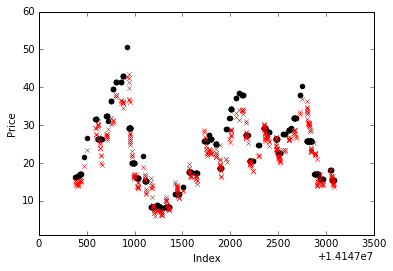

In [137]:
plt.scatter(zumz_features.index, zumz_prices, color='black')
plt.ylabel('Price')
plt.xlabel('Index')
plt.ylim(ymin=1)
plt.scatter(zumz_features.index, zumz_predictions, color='red', linewidth=.5, marker='x')

**IBM**

In [138]:
ibm = tick_gettr('IBM')
ibm_rsi = rsi(ibm, 9)
ibm['RSI'] = ibm_rsi
ibm = ibm[9:]
ibm.head(2)

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI
6491616,IBM,1962-01-15,4.917787,4.932992,4.917787,4.922132,251200.0,44.44
6491617,IBM,1962-01-16,4.917787,4.917787,4.870000,4.870000,251200.0,33.66


In [139]:
ibm = price_columns(ibm, 70, 30)
ibm.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price
6491616,IBM,1962-01-15,4.917787,4.932992,4.917787,4.922132,251200.0,44.44,NaN,NaN
6491617,IBM,1962-01-16,4.917787,4.917787,4.870000,4.870000,251200.0,33.66,NaN,NaN


In [140]:
base_ibm = ibm.copy()
base_ibm = ibm['Adj-C']

day_1 = base_ibm.shift(-1)
day_3 = base_ibm.shift(-3)
day_5 = base_ibm.shift(-5)
day_10 = base_ibm.shift(-10)

ibm['Day 1'] = day_1
ibm['Day 3'] = day_3
ibm['Day 5'] = day_5
ibm['Day 10'] = day_10

ibm.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price,Day 1,Day 3,Day 5,Day 10
6491616,IBM,1962-01-15,4.917787,4.932992,4.917787,4.922132,251200.0,44.44,NaN,NaN,4.870000,4.804835,4.800490,4.622373
6491617,IBM,1962-01-16,4.917787,4.917787,4.870000,4.870000,251200.0,33.66,NaN,NaN,4.791802,4.809179,4.752703,4.563724


In [141]:
ibm = sell_signal_prices(ibm, 70, 30)

In [142]:
ibm_features = ibm[rsi_features]
ibm_prices = ibm['Sell Signal Price']
i_obs = len(ibm)
ibm_prices = ibm_prices.reshape((i_obs, 1))

In [143]:
ibm_predictions = rsi_309_model.predict(ibm_features)

In [144]:
rsi_309_model.score(ibm_features, ibm_prices)

0.98963700485044326

In [145]:
np.sum((ibm_predictions - ibm_prices) ** 2)

89627.127300015272

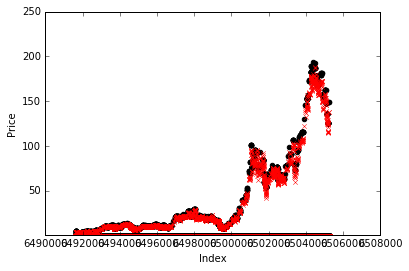

In [146]:
plt.scatter(ibm_features.index, ibm_prices, color='black')
plt.ylabel('Price')
plt.xlabel('Index')
plt.ylim(ymin=1)
plt.scatter(ibm_features.index, ibm_predictions, color='red', linewidth=.5, marker='x')

**X**

In [147]:
x = tick_gettr('X')
x_rsi = rsi(x, 9)
x['RSI'] = x_rsi
x = x[9:]
x.head(2)

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI
13945995,X,1991-04-25,15.606351,15.606351,15.380967,15.380967,99700.0,67.86
13945996,X,1991-04-26,15.380967,15.533254,14.924107,15.076393,88600.0,35.29


In [148]:
x = price_columns(x, 70, 30)
x.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price
13945995,X,1991-04-25,15.606351,15.606351,15.380967,15.380967,99700.0,67.86,NaN,NaN
13945996,X,1991-04-26,15.380967,15.533254,14.924107,15.076393,88600.0,35.29,NaN,NaN


In [149]:
base_x = x.copy()
base_x = x['Adj-C']

day_1 = base_x.shift(-1)
day_3 = base_x.shift(-3)
day_5 = base_x.shift(-5)
day_10 = base_x.shift(-10)

x['Day 1'] = day_1
x['Day 3'] = day_3
x['Day 5'] = day_5
x['Day 10'] = day_10

x.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price,Day 1,Day 3,Day 5,Day 10
13945995,X,1991-04-25,15.606351,15.606351,15.380967,15.380967,99700.0,67.86,NaN,NaN,15.076393,14.010386,14.619533,15.155582
13945996,X,1991-04-26,15.380967,15.533254,14.924107,15.076393,88600.0,35.29,NaN,NaN,13.937288,15.380967,14.771820,15.380967


In [150]:
x = sell_signal_prices(x, 70, 30)

In [151]:
x_features = x[rsi_features]
x_prices = x['Sell Signal Price']
x_obs = len(x)
x_prices = x_prices.reshape((x_obs, 1))

In [152]:
x_predictions = rsi_309_model.predict(x_features)

In [153]:
rsi_309_model.score(x_features, x_prices)

0.83073419185596586

In [154]:
np.sum((x_predictions - x_prices) ** 2)

173604.18356860543

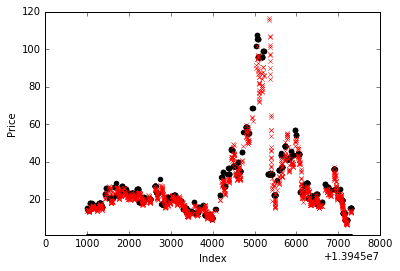

In [155]:
plt.scatter(x_features.index, x_prices, color='black')
plt.ylabel('Price')
plt.xlabel('Index')
plt.ylim(ymin=1)
plt.scatter(x_features.index, x_predictions, color='red', linewidth=.5, marker='x')

I will now write a small function to make the back of the envelope calculation for all the above.

In [156]:
quick_calc = [x, msft, zumz, ibm]

In [157]:
def back_envelope(stocks):
    """A simple function to calculate the difference between the sell & buy prices in the stock datasets."""
    
    for stock in stocks:
        #Get the ticker symbol.  This is used for display purposes.
        ticker = stock['Ticker']
        ticker = ticker.unique()
        comp_list = []

        for line in stock.iterrows():
            if line[1][14] > 0:
                asd = line[1][14] - line[1][9]
                comp_list.append(asd)

        print "for {}: # of transactions: {}.  Total value of transactions: {}.".format(
            ticker[0], len(comp_list), sum(comp_list))

In [158]:
back_envelope(quick_calc)

for X: # of transactions: 1222.  Total value of transactions: -1552.02945296.
for MSFT: # of transactions: 1041.  Total value of transactions: 474.602933111.
for ZUMZ: # of transactions: 455.  Total value of transactions: 104.58.
for IBM: # of transactions: 2231.  Total value of transactions: 1140.24345053.


Clearly some interesting results, particularly for **X**.  Below I will include another plot in order to get a closer look at **X**.

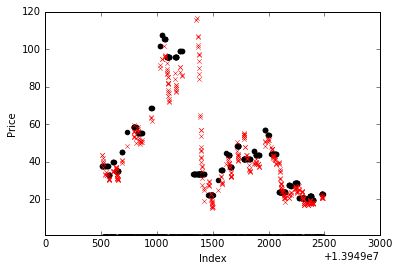

In [159]:
plt.scatter(x_features[3516:5500].index, x_prices[3516:5500], color='black')
plt.ylabel('Price')
plt.xlabel('Index')
plt.ylim(ymin=1)
plt.scatter(x_features[3516:5500].index, x_predictions[3516:5500], color='red', linewidth=.5, marker='x')

In this plot we can see where some model that is highly predictive can have some disastrous results.  As alluded to earlier, without risk management & position sizing a predictive model does not really serve much use.  Although, **X** was the least predictive (with an ~83% model score) my back of the envelope calculation demonstrates that a mechanistic implementation of a simple buy/sell rule can lead to a very negative outcome.

Also important to point what is happening in the chart above.  This selection was during the financial crises, where asset prices were dropping rapidly and by large percentages.  It is important to point out that this is not an instance of corrupt data, but a rapid change in the environment where the asset price took a tremndous hit.  So this chart seems to indicate that the model will have a hard time to make accurate predictions in periods where there are significant price swings that differing from the preceeding trends.


**Below I plot the some of the stock data again in order to get a more readable plots.**

In [160]:
new_x = x_features[3516:5500]

In [161]:
new_x_dates = x[3516:5500]['Date']

In [162]:
new_x['Date'] = new_x_dates

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [163]:
new_x_predict = x_predictions[3516:5500]

In [164]:
new_x['Predicted'] = new_x_predict

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [165]:
new_x_prices = x_prices[3516:5500]
new_x['Price'] = new_x_prices

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [166]:
from dateutil.parser import parse

asd = new_x['Date'].tolist()
asd = [parse(i) for i in asd]

### Zoom in on X

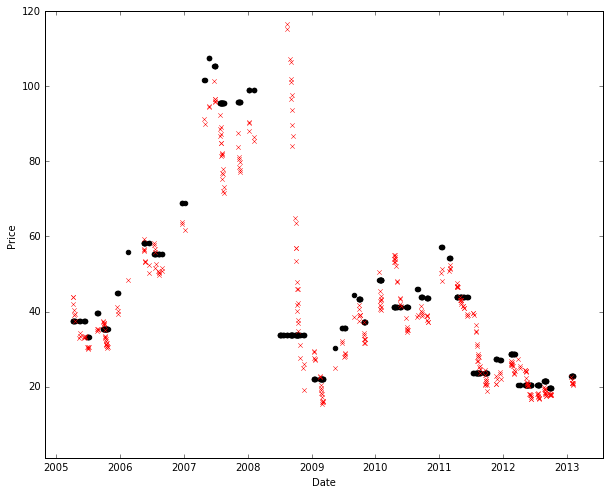

In [167]:
plt.figure(figsize=(10,8))
plt.scatter(asd, new_x.Price, color='black')
plt.ylabel('Price')
plt.xlabel('Date')
plt.ylim(ymin=1)
plt.scatter(asd, new_x.Predicted, color='red', linewidth=.5, marker='x')

### All X Data

In [168]:
xasd = x['Date'].tolist()
xasd = [parse(i) for i in xasd]

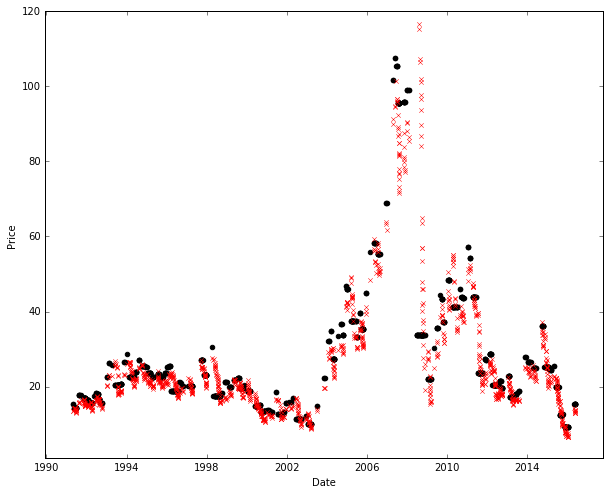

In [169]:
plt.figure(figsize=(10,8))
plt.scatter(xasd, x_prices, color='black')
plt.ylabel('Price')
plt.xlabel('Date')
plt.ylim(ymin=1)
plt.scatter(xasd, x_predictions, color='red', linewidth=.5, marker='x')